In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-8dgkore4
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-8dgkore4
  Resolved https://github.com/albumentations-team/albumentations to commit 47c24503e0636f258e2af2b18e552d52271308bf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 34.52 MiB/s, done.


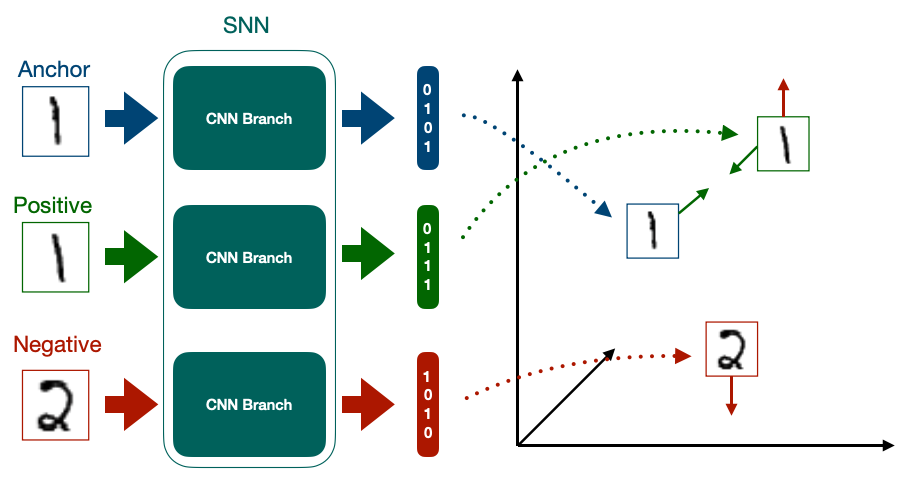

# Imports

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'


In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[14]
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)


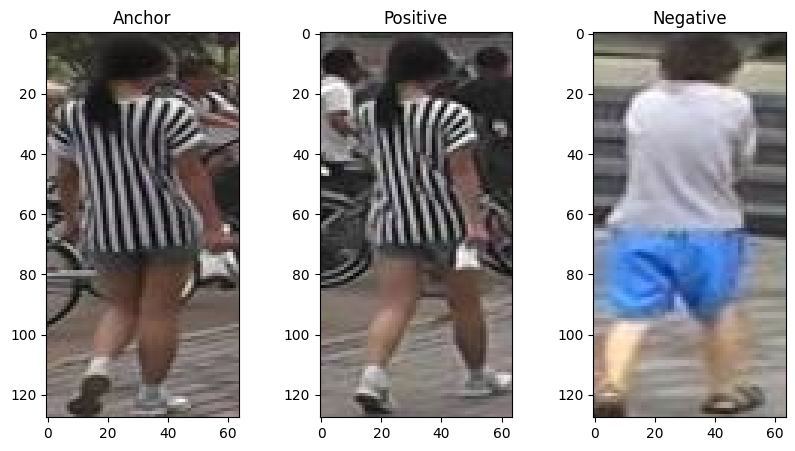

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))
ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# Create APN Dataset

In [ ]:
class APN_Dataset(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"size of trainset: {len(trainset)}")
print(f"size of validset: {len(validset)}")

size of trainset: 3200
size of validset: 800


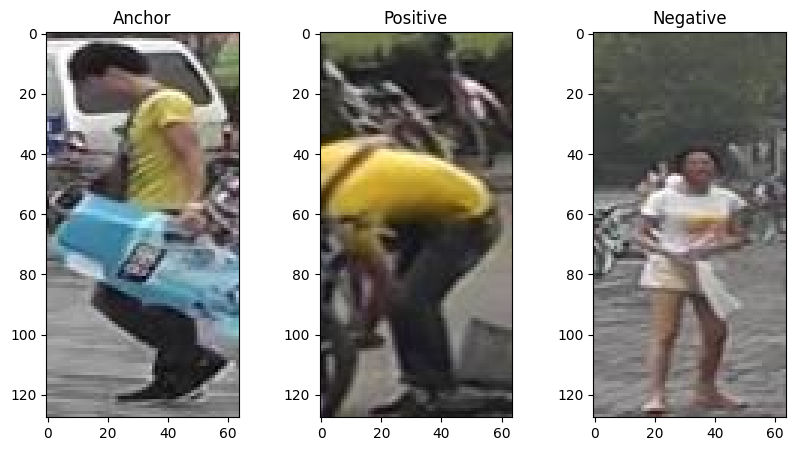

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A, P, N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [ ]:
class APN_Model(nn.Module):
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)

    return embeddings

In [ ]:
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = critetion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader, criterion):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = critetion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print('SAVED_WEIGHTS_SUCCESS')

  print(f"EPOCHS: {i+1}, train_loss : {train_loss}, valid_loss: {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 1, train_loss : 0.28721380576491357, valid_loss: 0.31034443497657777


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 2, train_loss : 0.14507979154586792, valid_loss: 0.1849866110086441


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 3, train_loss : 0.08771763786673546, valid_loss: 0.15038804292678834


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 4, train_loss : 0.05328722737729549, valid_loss: 0.14647871434688567


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


EPOCHS: 5, train_loss : 0.07688960373401642, valid_loss: 0.20592232108116149


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


EPOCHS: 6, train_loss : 0.05073591701686382, valid_loss: 0.23639834940433502


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


EPOCHS: 7, train_loss : 0.049458035975694654, valid_loss: 0.17304377734661103


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


EPOCHS: 8, train_loss : 0.05380562618374825, valid_loss: 0.2198355484008789


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


EPOCHS: 9, train_loss : 0.08070590019226075, valid_loss: 0.21527273893356325


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


EPOCHS: 10, train_loss : 0.059292191565036775, valid_loss: 0.18837633609771728


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 11, train_loss : 0.06883205585181713, valid_loss: 0.14550409466028214


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 12, train_loss : 0.041544008180499074, valid_loss: 0.09757645100355149


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 13, train_loss : 0.023800736367702482, valid_loss: 0.09545966386795043


100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 14, train_loss : 0.009380386173725129, valid_loss: 0.08644006609916687


100%|██████████| 25/25 [00:04<00:00,  5.82it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 15, train_loss : 0.005792341753840446, valid_loss: 0.07549991428852082


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)
  return df_enc


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

<ipython-input-53-fb78bba7c639>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
100%|██████████| 4000/4000 [00:47<00:00, 

In [ ]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.017246,0.451888,0.217985,-0.139357,-0.161696,-0.507841,0.450184,0.383817,0.212024,...,-0.897407,-0.664085,-0.389354,0.637937,-0.758587,0.783972,0.007440,0.898596,0.066732,0.796363
1,1420_c3s3_061978_03.jpg,-0.106522,0.690366,0.123862,-0.301079,-0.278173,-0.990724,0.767496,0.380391,0.373873,...,-1.188302,-0.311245,-0.582090,0.944374,-0.601337,0.577906,-0.079559,1.544423,0.059659,0.643016
2,1420_c5s3_062565_05.jpg,-0.266219,0.580536,0.041184,-0.309016,-0.354140,-0.702023,0.449948,0.433065,0.166342,...,-1.062622,-0.615969,-0.359321,0.803295,-0.775851,0.899863,0.023265,1.282358,-0.088286,0.916486
3,1420_c6s3_085592_04.jpg,0.554155,0.354600,0.218879,-0.535411,0.352391,-0.309472,0.890672,0.421168,0.272454,...,-0.660108,-0.204373,-0.301010,0.537923,-0.593967,0.866834,0.136009,0.140537,0.361084,0.488063
4,0663_c5s3_085987_03.jpg,1.022322,0.194451,-0.286310,0.961329,0.630773,0.345852,0.524888,-0.057942,0.218477,...,1.072557,0.015514,0.194216,0.260638,0.409576,0.521476,-0.161257,-1.917823,-0.047134,-0.753911


# Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

In [ ]:
idx = 4
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()


In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i: i+1, :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

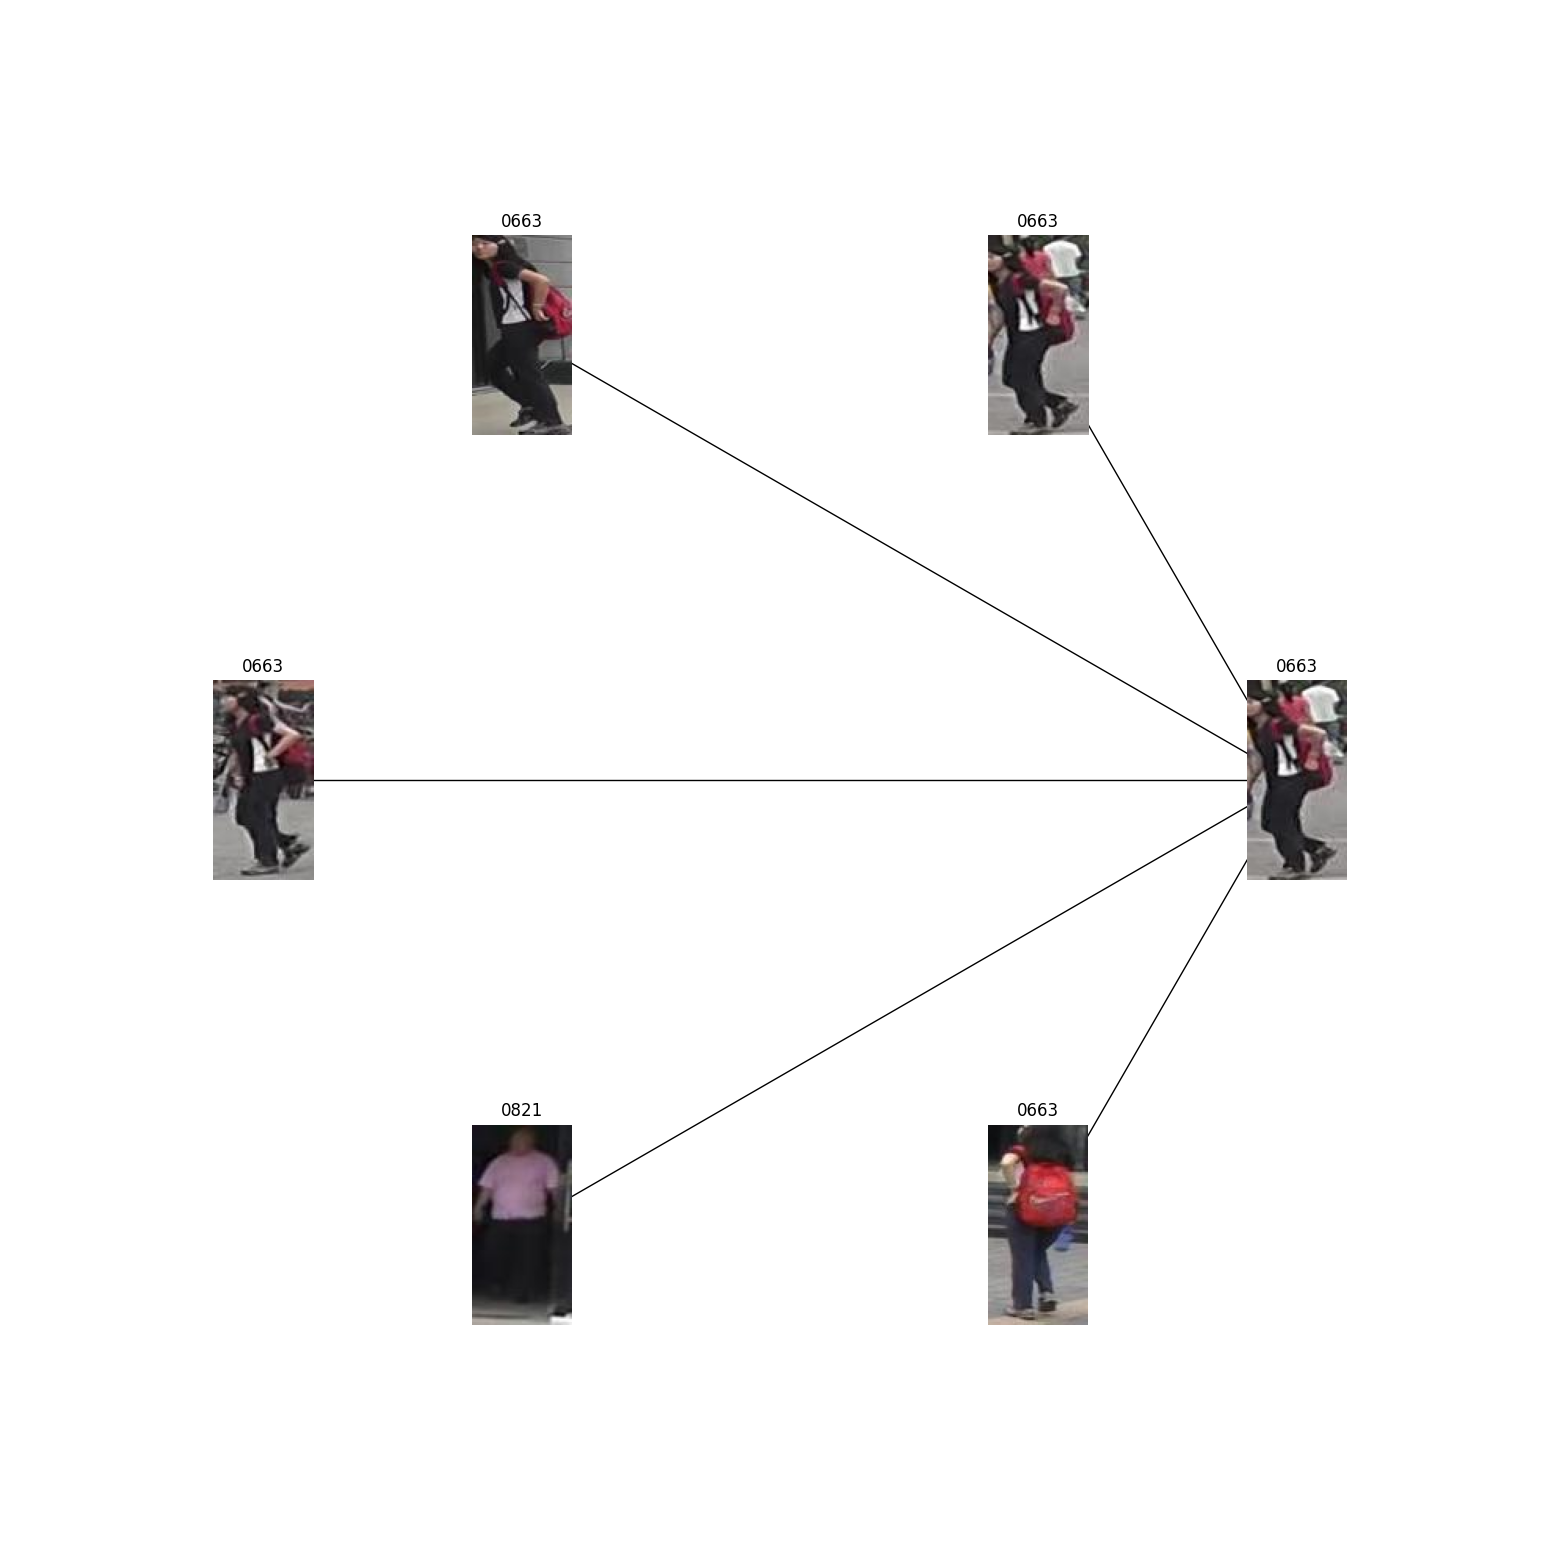

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);